<a href="https://colab.research.google.com/github/zeinabkamkar98/graph_simulation/blob/main/graph_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load github datasets**

If you wanna use github datasets run below cell. This datasets are limited (10 datasets), They're just for test.

In [66]:
!git clone https://github.com/zeinabkamkar98/graph_simulation.git

fatal: destination path 'graph_simulation' already exists and is not an empty directory.


**Essential Libs**

In [47]:
import random
import numpy as np

from scipy.special import  rel_entr

import networkx as nx
from networkx.drawing import draw_networkx

import matplotlib.pyplot as plt


**Utils**


In [60]:
def read_graph_file(path):
    G = nx.Graph()
    data = np.loadtxt(path, delimiter=',').astype(int)
    data_tuple = list(map(tuple, data))
    G.add_edges_from(data_tuple)
    return G


def create_random_graph(nodes_count, edges_count ):
    return nx.gnm_random_graph(nodes_count, edges_count)


def add_features_to_graph(G: nx.Graph):
    for node in G.nodes:
        neighbors = G.neighbors(node)
        degrees = [G.degree(neighbor) for neighbor in neighbors]
        min_degree = np.min(degrees) if degrees else 0
        max_degree = np.max(degrees) if degrees else 0
        mean_degree = np.mean(degrees) if degrees else 0
        median_degree = np.median(degrees) if degrees else 0
        G.nodes[node]["features"] = np.array(
            [
                mean_degree,
                median_degree,
                max_degree,
                min_degree,
            ]
        )
    for edge in G.edges:
        G.edges[edge]["features"] = np.zeros(5)
        G.edges[edge]["features"][:2] = (
            G.nodes[edge[0]]["features"][:2] + G.nodes[edge[1]]["features"][:2]
        )

        max_deg = max(G.nodes[edge[0]]["features"][2], G.nodes[edge[1]]["features"][2])
        min_deg = min(G.nodes[edge[0]]["features"][3], G.nodes[edge[1]]["features"][3])
        G.edges[edge]["features"][2] = max_deg
        G.edges[edge]["features"][3] = min_deg
        G.edges[edge]["features"][4] = max_deg -min_deg


def calculate_divergence(g1, g2):
    epsilon = 1e-10

    g1_features_data = np.concatenate(
        [np.array([v]) for v in nx.get_edge_attributes(g1, "features").values()]
    )
    g2_features_data = np.concatenate(
        [np.array([v]) for v in nx.get_edge_attributes(g2, "features").values()]
    )

    feature_divergence = np.zeros(g1_features_data.shape[1])

    for i in range(5):
      data= g1_features_data[:, i] + g2_features_data[:, i]
      hist_range=(np.min(data), np.max(data))
      g1_hist, _ = np.histogram(g1_features_data[:, i], range=hist_range)
      g2_hist, _ = np.histogram(g2_features_data[:, i], range=hist_range)
      feature_divergence[i] = np.sum(
          rel_entr(g1_hist + epsilon / np.sum(g1_hist), g2_hist + epsilon / np.sum(g2_hist))
      )

    # g1_hist, _ = np.histogram(g1_features_data[:, 1], range=(2, len(g1.nodes()) * 2))
    # g2_hist, _ = np.histogram(g2_features_data[:, 1], range=(2, len(g1.nodes()) * 2))
    # feature_divergence[1] = np.sum(
    #     rel_entr(g1_hist + epsilon / np.sum(g1_hist), g2_hist + epsilon / np.sum(g2_hist))
    # )  # median

    # g1_hist, _ = np.histogram(g1_features_data[:, 2], range=(1, len(g1.nodes())))
    # g2_hist, _ = np.histogram(g2_features_data[:, 2], range=(1, len(g1.nodes())))
    # feature_divergence[2] = np.sum(
    #     rel_entr(g1_hist + epsilon / np.sum(g1_hist), g2_hist + epsilon / np.sum(g2_hist))
    # )  # max

    # g1_hist, _ = np.histogram(g1_features_data[:, 3], range=(1, len(g1.nodes())))
    # g2_hist, _ = np.histogram(g2_features_data[:, 3], range=(1, len(g1.nodes())))
    # feature_divergence[3] = np.sum(
    #     rel_entr(g1_hist + epsilon / np.sum(g1_hist), g2_hist + epsilon / np.sum(g2_hist))
    # )  # min

    # g1_hist, _ = np.histogram(g1_features_data[:, 4], range=(0, len(g1.nodes())))
    # g2_hist, _ = np.histogram(g2_features_data[:, 4], range=(0, len(g1.nodes())))
    # feature_divergence[4] = np.sum(
    #     rel_entr(g1_hist + epsilon / np.sum(g1_hist), g2_hist + epsilon / np.sum(g2_hist))
    # )  # range

    return feature_divergence

**Original Graph**

Generate random graph just for test. Later I will change this part with importing real graph.

None

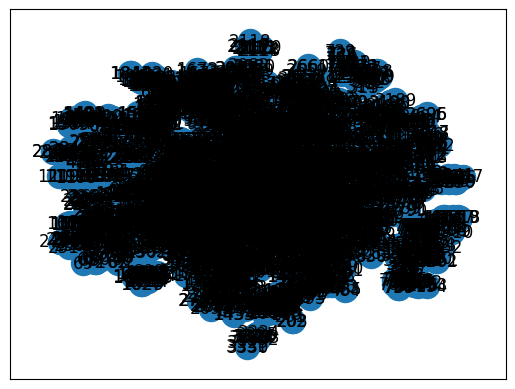

In [5]:
graphs_name = ['DHFR','BZR','COX2','AIDS','ENZYMES','DD','MUTAG','NCI1','PROTEINS_full','PTC_MR']

selected_graph_name= graphs_name[0]
graph = read_graph_file('graph_simulation/DATASETS/MUTAG/MUTAG_A.txt')

# rand = random.Random(0)
# graph = create_random_graph(40, 300, rand)

add_features_to_graph(graph)
display(draw_networkx(graph,  with_labels=False))



In [ ]:
# node_labels = {
#     node: f"{node} mean:{attr['features'][0]:.3f} median:{attr['features'][1]} max:{attr['features'][2]} min:{attr['features'][3]}"
#     for node, attr in graph.nodes(data=True)
# }

# edge_labels = {
#     (u, v): {
#         "mean": attr["features"][0],
#         "median": attr["features"][1],
#         "max": attr["features"][2],
#         "min": attr["features"][3],
#         "range": attr["features"][4]
#     }
#     for u, v, attr in graph.edges(data=True)
# }
#
# display(edge_labels)
# display(node_labels)

**Complement Of Original Graph**


In [12]:
graph_complement = nx.complement(graph)
add_features_to_graph(graph_complement)
display(draw_networkx(graph_complement,  with_labels=False))


KeyboardInterrupt: ignored

In [ ]:
# node_labels = {
#     node: f"{node} mean:{attr['features'][0]:.3f} median:{attr['features'][1]} max:{attr['features'][2]} min:{attr['features'][3]}"
#     for node, attr in graph_complement.nodes(data=True)
# }

# edge_labels = {
#     (u, v): {
#         "mean": attr["features"][0],
#         "median": attr["features"][1],
#         "max": attr["features"][2],
#         "min": attr["features"][3],
#         "range": attr["features"][4]
#     }
#     for u, v, attr in graph_complement.edges(data=True)
# }
# display(edge_labels)
# display(node_labels)

**Simulate Graph**

In this step, I generated a random graph with same node and edge number of the original graph

In [65]:

best_G = None
best_G_div = np.inf
best_G_comp = None
best_G_comp_div = np.inf

# Set a random seed (you can use any integer as the seed)
random_seed = random.randint(1, 1000)
random.seed(random_seed)

for i in range(1):
    random_graph = create_random_graph(len(graph.nodes), len(graph.edges))
    add_features_to_graph(random_graph)
    div = np.sum(calculate_divergence(graph, random_graph))

    if div < best_G_div:
        best_G_div = div
        best_G = random_graph
    print(f"{i}: G", div)

    # random_graph_comp = nx.complement(random_graph)
    # add_features_to_graph(random_graph_comp)
    # div = np.sum(calculate_divergence(graph_complement, random_graph_comp))

    # if div < best_G_comp_div:
    #     best_G_comp_div = div
    #     best_G_comp = random_graph
    # print(f"{i}: G_comp", div)

0: G 15954.545448919165


In [10]:
print(best_G_div)
nx.draw_networkx(best_G)

0.0


KeyboardInterrupt: ignored